# Random Forest Classifier

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from funciones_mecanizados import normalizar
from funciones_mecanizados import cortar

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

In [2]:
# Cargamos el dataset preprocesado.
h1_norm = pd.read_csv('data/panel1_H1_norm.csv')
h2_norm = pd.read_csv('data/panel2_H2_norm.csv')
h3_norm = pd.read_csv('data/panel1_H3_norm.csv')

#Elminamos el ruido
nivel_filtro = 0
data = [h1_norm, h2_norm,h3_norm]
for dat in data:
    dat.drop(dat[dat['ENER']<nivel_filtro].index, axis=0, inplace=True)


columnas = ['RMS','AMP','ENER','P_FRQ','PCNTS','C_FRQ', 'I_FRQ','A_FRQ','P_MARSE',
        'R_FRQ','DURATION','ASL','COUN','ABS_ENERGY', 'SIG_STRNGTH','RISE']


mecanizados = pd.concat([h1_norm, h2_norm, h3_norm])
mecanizados.reset_index(drop=True, inplace=True)

#Nos quedamos con algunos datos del fresado
#corte1 = [0,2]
#corte2 = [2,2.6]

#fresado_h1 = pd.concat([cortar(h1_norm, corte1), cortar(h1_norm, corte2)])
#fresado_h2 = pd.concat([cortar(h2_norm, corte1), cortar(h2_norm, corte2)])
#fresado_h3 = pd.concat([cortar(h3_norm, corte1), cortar(h3_norm, corte2)])

#print('H1:',fresado_h1.shape)
#print('H2:',fresado_h2.shape)
#print('H3:',fresado_h3.shape)

In [3]:
#Juntamos todos los datos en un solo DF
#fresado = pd.concat([fresado_h1, fresado_h2, fresado_h3])

### TRAIN/TEST SPLIT

In [4]:

train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=.20, random_state=11)

for train_index, test_index in train_test_split.split(mecanizados, mecanizados['Herramienta']):
    train = mecanizados.iloc[train_index]
    test = mecanizados.iloc[test_index]

In [5]:
print('Datos totales:',mecanizados.shape[0])
print('Train:        ',train.shape[0])
print('Test:         ',test.shape[0])

Datos totales: 9014
Train:         7211
Test:          1803


In [6]:
#Datos para la validación cruzada
#Hacemos una copia y eliminamos las variables que no vamos a usar.

X = train.copy()
y = X.pop('Herramienta')
X.drop(['CH','Tiempo', 'Mecanizado'], axis=1, inplace=True)

In [7]:
#Datos para entrenar y probar el modelo.
y_train = train.Herramienta
y_test = test.Herramienta

X_train = train[columnas]
X_test = test[columnas]

## Modelos

### Simple sin ajustes

In [8]:
RFCmodel_ = RandomForestClassifier(random_state = 14)
RFCmodel_.fit(X_train, y_train)

prediccion_ = RFCmodel_.predict(X_train)


score_ = round(accuracy_score(y_train, prediccion_),4)
print('################# Puntuación ##################')
print('###################',score_,'####################')

#Matriz de confusión
conf_matrix = confusion_matrix(y_train, prediccion_,labels=['H1','H2','H3'])
print(pd.DataFrame(data=conf_matrix, index=['H1','H2','H3'], columns=['H1_predicción','H2_predicción','H3_predicción']))

print('')
print('')
print('#####################################################')
print('##################### Scores ########################')
print('#####################################################')
print('')

#Scores
print (classification_report(y_train, prediccion_))

################# Puntuación ##################
################### 1.0 ####################
    H1_predicción  H2_predicción  H3_predicción
H1           2486              0              0
H2              0           2328              0
H3              0              0           2397


#####################################################
##################### Scores ########################
#####################################################

              precision    recall  f1-score   support

          H1       1.00      1.00      1.00      2486
          H2       1.00      1.00      1.00      2328
          H3       1.00      1.00      1.00      2397

    accuracy                           1.00      7211
   macro avg       1.00      1.00      1.00      7211
weighted avg       1.00      1.00      1.00      7211



In [9]:
prediccion_ = RFCmodel_.predict(X_test)


score_ = round(accuracy_score(y_test, prediccion_),4)
print('################# Puntuación ##################')
print('###################',score_,'####################')

#Matriz de confusión
conf_matrix = confusion_matrix(y_test, prediccion_,labels=['H1','H2','H3'])
print(pd.DataFrame(data=conf_matrix, index=['H1','H2','H3'], columns=['H1_predicción','H2_predicción','H3_predicción']))

print('')
print('')
print('#####################################################')
print('##################### Scores ########################')
print('#####################################################')
print('')

#Scores
print (classification_report(y_test, prediccion_))

################# Puntuación ##################
################### 0.9268 ####################
    H1_predicción  H2_predicción  H3_predicción
H1            582             17             23
H2             25            539             18
H3             27             22            550


#####################################################
##################### Scores ########################
#####################################################

              precision    recall  f1-score   support

          H1       0.92      0.94      0.93       622
          H2       0.93      0.93      0.93       582
          H3       0.93      0.92      0.92       599

    accuracy                           0.93      1803
   macro avg       0.93      0.93      0.93      1803
weighted avg       0.93      0.93      0.93      1803



### Ajuste de los Hiperparámetros

In [10]:
grilla_parametros =  {'n_estimators': [240,250,260],
              'max_features': [12,13,14,15,16],
              'max_depth'   : [None],
              'criterion'   : ['gini', 'entropy']
             }


kf= StratifiedShuffleSplit(n_splits=5, test_size=.20, random_state=11)

clasificador = GridSearchCV(RandomForestClassifier(random_state = 14),
                            param_grid=grilla_parametros, 
                            cv=kf,
                            verbose=2, 
                            n_jobs=-1
                           )
clasificador.fit(X_train, y_train)

print(clasificador.best_params_, ":", clasificador.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.7min finished


{'criterion': 'entropy', 'max_depth': None, 'max_features': 13, 'n_estimators': 250} : 0.9412335412335413


In [11]:
forest_model = RandomForestClassifier(n_estimators=clasificador.best_params_['n_estimators'], 
                                      max_features=clasificador.best_params_['max_features'], 
                                      criterion=clasificador.best_params_['criterion'], 
                                      max_depth=None, random_state = 14)
forest_model.fit(X_train, y_train)
prediccion = forest_model.predict(X_train)
print(accuracy_score(y_train, prediccion))

score_ = round(accuracy_score(y_train, prediccion),4)
print('################# Puntuación ##################')
print('###################',score_,'####################')

#Matriz de confusión
conf_matrix = confusion_matrix(y_train, prediccion,labels=['H1','H2','H3'])
print(pd.DataFrame(data=conf_matrix, index=['H1','H2','H3'], columns=['H1_predicción','H2_predicción','H3_predicción']))

print('')
print('')
print('#####################################################')
print('##################### Scores ########################')
print('#####################################################')
print('')

#Scores
print (classification_report(y_train, prediccion))

1.0
################# Puntuación ##################
################### 1.0 ####################
    H1_predicción  H2_predicción  H3_predicción
H1           2486              0              0
H2              0           2328              0
H3              0              0           2397


#####################################################
##################### Scores ########################
#####################################################

              precision    recall  f1-score   support

          H1       1.00      1.00      1.00      2486
          H2       1.00      1.00      1.00      2328
          H3       1.00      1.00      1.00      2397

    accuracy                           1.00      7211
   macro avg       1.00      1.00      1.00      7211
weighted avg       1.00      1.00      1.00      7211



In [12]:
# Vemos como funciona nuestro modelo con datos que nunca vio
prediccion = forest_model.predict(X_test)
print(accuracy_score(y_test, prediccion))

score_ = round(accuracy_score(y_test, prediccion),4)
print('################# Puntuación ##################')
print('###################',score_,'####################')

#Matriz de confusión
conf_matrix = confusion_matrix(y_test, prediccion,labels=['H1','H2','H3'])
print(pd.DataFrame(data=conf_matrix, index=['H1','H2','H3'], columns=['H1_predicción','H2_predicción','H3_predicción']))

print('')
print('')
print('#####################################################')
print('##################### Scores ########################')
print('#####################################################')
print('')

#Scores
print (classification_report(y_test, prediccion))

0.9517470881863561
################# Puntuación ##################
################### 0.9517 ####################
    H1_predicción  H2_predicción  H3_predicción
H1            595              7             20
H2             15            554             13
H3             14             18            567


#####################################################
##################### Scores ########################
#####################################################

              precision    recall  f1-score   support

          H1       0.95      0.96      0.96       622
          H2       0.96      0.95      0.95       582
          H3       0.94      0.95      0.95       599

    accuracy                           0.95      1803
   macro avg       0.95      0.95      0.95      1803
weighted avg       0.95      0.95      0.95      1803



Puntaje de los parámetros:
1. Parámetro 3 (0.302944)
2. Parámetro 6 (0.139622)
3. Parámetro 11 (0.084894)
4. Parámetro 1 (0.064586)
5. Parámetro 0 (0.056457)
6. Parámetro 8 (0.054658)
7. Parámetro 7 (0.048471)
8. Parámetro 10 (0.047654)
9. Parámetro 13 (0.045323)
10. Parámetro 12 (0.039924)
11. Parámetro 5 (0.028897)
12. Parámetro 9 (0.023444)
13. Parámetro 15 (0.019488)
14. Parámetro 4 (0.015440)
15. Parámetro 2 (0.014928)
16. Parámetro 14 (0.013269)


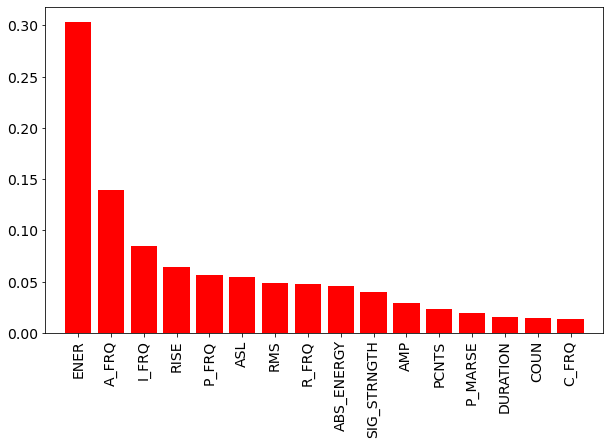

In [15]:
import numpy as np
importances = forest_model.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Puntaje de los parámetros:")

for f in range(X.shape[1]-1):
    print("%d. Parámetro %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(10,6))

plt.bar(X.columns[indices], importances[indices], color="r", align="center")
plt.xticks(X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]-1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()